To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### News

**[NEW] We've fixed many bugs in Phi-4** which greatly increases Phi-4's accuracy. See our [blogpost](https://unsloth.ai/blog/phi4)

[NEW] You can view all Phi-4 model uploads with our bug fixes including [dynamic 4-bit quants](https://unsloth.ai/blog/dynamic-4bit), GGUF & more [here](https://huggingface.co/collections/unsloth/phi-4-all-versions-677eecf93784e61afe762afa)

[NEW] As of Novemeber 2024, Unsloth now supports [vision finetuning](https://unsloth.ai/blog/vision)!


### Installation

In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

### Unsloth

In [2]:
from unsloth import FastLanguageModel  # FastVisionModel for LLMs
import torch
max_seq_length = 2048  # Choose any! We auto support RoPE Scaling internally!
load_in_4bit = True  # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",  # Llama-3.1 2x faster
    "unsloth/Mistral-Small-Instruct-2409",  # Mistral 22b 2x faster!
    "unsloth/Phi-4",  # Phi-4 2x faster!
    "unsloth/Phi-4-unsloth-bnb-4bit",  # Phi-4 Unsloth Dynamic 4-bit Quant
    "unsloth/gemma-2-9b-bnb-4bit",  # Gemma 2x faster!
    "unsloth/Qwen2.5-7B-Instruct-bnb-4bit"  # Qwen 2.5 2x faster!
    "unsloth/Llama-3.2-1B-bnb-4bit",  # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
]  # More models at https://docs.unsloth.ai/get-started/all-our-models

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-4",
    max_seq_length = max_seq_length,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.1.5: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.1.5 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the `Phi-4` format for conversation style finetunes. We use [Maxime Labonne's FineTome-100k](https://huggingface.co/datasets/mlabonne/FineTome-100k) dataset in ShareGPT style. But we convert it to HuggingFace's normal multiturn format `("role", "content")` instead of `("from", "value")`/ Phi-4 renders multi turn conversations like below:

```
<|im_start|>user<|im_sep|>Hello!<|im_end|>
<|im_start|>assistant<|im_sep|>Hi! How can I help?<|im_end|>
<|im_start|>user<|im_sep|>What is 2+2?<|im_end|>
```

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, phi3, phi4, llama3` and more.

In [4]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["Instruction"]
    inputs       = examples["Input"]
    outputs      = examples["Output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

from datasets import load_dataset
dataset = load_dataset("json" , data_files = "fdata.jsonl" , split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/507 [00:00<?, ? examples/s]

We now use `standardize_sharegpt` to convert ShareGPT style datasets into HuggingFace's generic format. This changes the dataset from looking like:
```
{"from": "system", "value": "You are an assistant"}
{"from": "human", "value": "What is 2+2?"}
{"from": "gpt", "value": "It's 4."}
```
to
```
{"role": "system", "content": "You are an assistant"}
{"role": "user", "content": "What is 2+2?"}
{"role": "assistant", "content": "It's 4."}
```

In [5]:
dataset[5]["text"]

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n\nYou are a mathematics expert specializing in visualizing and analyzing scenarios using Python’s Matplotlib library. Your task is to:\n\t1.\tAnalyze the Scenario (Chain of Thought): Carefully analyze the provided detailed scenario. Break it into logical steps, considering mathematical principles and visualization requirements. Use a clear reasoning process before deciding the best approach to generate the output.\n\t2.\tPython Matplotlib Code Only: Generate Python matplotlib code as the sole output to visualize the scenario. The code should:\n\t•\tBe error-free and functional.\n\t•\tAdhere to a minimalistic style with concise, essential elements.\n\t•\tUse minimal text annotations placed in the free space at the top or bottom of the visual, as needed.\n\t3.\tFocus on Simplicity: Ensure that the visualization

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [8]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 6,
        gradient_accumulation_steps = 3,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 50,
        learning_rate = (2e-4)*2,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2):   0%|          | 0/507 [00:00<?, ? examples/s]

We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs.

We verify masking is actually done:

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 507 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 6 | Gradient Accumulation steps = 3
\        /    Total batch size = 18 | Total steps = 50
 "-____-"     Number of trainable parameters = 65,536,000


Step,Training Loss
1,1.373700


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

959.8611 seconds used for training.
16.0 minutes used for training.
Peak reserved memory = 12.361 GB.
Peak reserved memory for training = 2.318 GB.
Peak reserved memory % of max memory = 83.815 %.
Peak reserved memory for training % of max memory = 15.717 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

**[NEW] Try 2x faster inference in a free Colab for Llama-3.1 8b Instruct [here](https://colab.research.google.com/drive/1T-YBVfnphoVc8E2E854qF3jdia2Ll2W2?usp=sharing)**

We use `min_p = 0.1` and `temperature = 1.5`.

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-4",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(
    input_ids = inputs, max_new_tokens = 64, use_cache = True, temperature = 1.5, min_p = 0.1
)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|im_start|>user<|im_sep|>Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,<|im_end|><|im_start|>assistant<|im_sep|>The next number in the Fibonacci sequence is 13. The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding ones, usually starting with 0 and 1. In this case, the sequence starts with 1 and 1, and each subsequent number is the sum of the']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(
    input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
    use_cache = True, temperature = 1.5, min_p = 0.1
)

The next number in the Fibonacci sequence is 13. The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding ones, usually starting with 0 and 1. In this case, the sequence starts with 1 and 1, and each subsequent number is the sum of the two preceding numbers. So, the next number after 8 is 13, which is the sum of 5 and 8.<|im_end|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/vocab.json',
 'lora_model/merges.txt',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [5]:
max_seq_length = 2048  # Choose any! We auto support RoPE Scaling internally!
load_in_4bit = True  # Use 4bit quantization to reduce memory usage. Can be False.
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "Raja2/lora_phi4", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Describe a tall tower in the capital of France."},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(
    input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
    use_cache = True, temperature = 1.5, min_p = 0.1
)

==((====))==  Unsloth 2025.1.5: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/160k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.39G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/170 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/917k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.15M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/524M [00:00<?, ?B/s]

Unsloth 2025.1.5 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


The Eiffel Tower stands as an iconic symbol of Paris, the capital of France. Constructed between 1887 and 1889 as the entrance to the 1889 World's Fair, it was initially met with skepticism from the public and artists alike. However, it has since become one of the most recognizable structures in the world.

Standing at approximately 324 meters (1,063 feet) tall, the Eiffel Tower was the tallest man-made structure in the world until the completion of the Chrysler Building in New York in 1930. It consists of three levels, with restaurants on the first and second floors and an


In [6]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "you are a mathemetics , matplotlib expert where you have to gave the code to generate the image based on the discription , the generated code should render image as per user req", # instruction
        "create a right angled triagngle with 4 and 5 as lengths", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 1000)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
you are a mathemetics , matplotlib expert where you have to gave the code to generate the image based on the discription , the generated code should render image as per user req

### Input:
create a right angled triagngle with 4 and 5 as lengths

### Response:
```python
import matplotlib.pyplot as plt
import numpy as np

# Define the sides of the triangle
a = 4
b = 5

# Calculate the hypotenuse using the Pythagorean theorem
c = np.sqrt(a**2 + b**2)

# Define the vertices of the triangle
A = (0, 0)
B = (a, 0)
C = (0, b)

# Create the plot
plt.figure(figsize=(6, 6))
plt.plot([A[0], B[0]], [A[1], B[1]], 'b-', label=f'{a} units')
plt.plot([B[0], C[0]], [B[1], C[1]], 'g-', label=f'{b} units')
plt.plot([C[0], A[0]], [C[1], A[1]], 'r-', label=f'{c:.2f} units')

# Annotate the vertices
plt.text(A[0] - 0.2, A[1] - 0.2, 'A

You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [33]:
sys_prompt = """
  "you are a mathemetics , matplotlib expert where you have to gave the code to generate the image based on the discription , the generated code should render image as per user req",
"""
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        sys_prompt,
        "Draw the polar plot of r = sin(3\theta), and include markers at \theta = 0, \pi/3, 2\pi/3, and \pi for \theta \in [0, 2\pi].", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 2000)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:

  "you are a mathemetics , matplotlib expert where you have to gave the code to generate the image based on the discription , the generated code should render image as per user req", 


### Input:
Draw the polar plot of r = sin(3	heta), and include markers at 	heta = 0, \pi/3, 2\pi/3, and \pi for 	heta \in [0, 2\pi].

### Response:
```python
import matplotlib.pyplot as plt
import numpy as np

# Define theta range
theta = np.linspace(0, 2 * np.pi, 1000)

# Define the polar equation
r = np.sin(3 * theta)

# Define marker positions
marker_theta = [0, np.pi/3, 2*np.pi/3, np.pi]
marker_r = np.sin(3 * marker_theta)

# Create the polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection='polar')
ax.plot(theta, r, label=r'$r = \sin(3\theta)$')

# Add markers
ax.scatter(marker_theta, marker_r, color='red', z

ValueError: x and y must be the same size

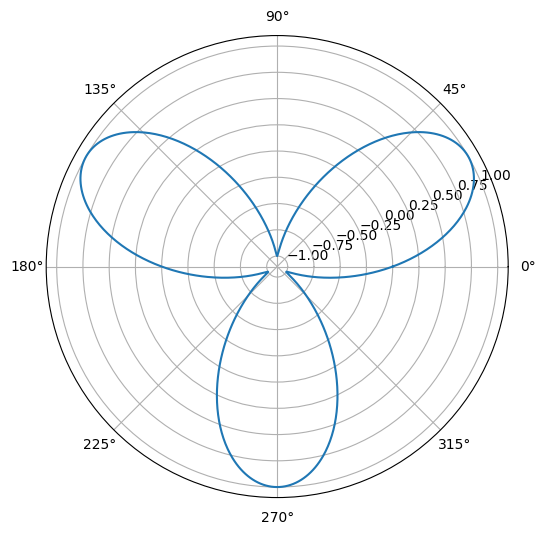

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Define theta range
theta = np.linspace(0, 2 * np.pi, 1000)

# Define the polar equation
r = np.sin(3 * theta)

# Define marker positions
marker_theta = [0, np.pi/3, 2*np.pi/3, np.pi]
marker_r = np.sin(3 * marker_theta)

# Create the polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection='polar')
ax.plot(theta, r, label=r'$r = \sin(3\theta)$')

# Add markers
ax.scatter(marker_theta, marker_r, color='red', zorder=5)

# Annotate markers
for i, (theta, r) in enumerate(zip(marker_theta, marker_r)):
    ax.annotate(f'({theta:.2f}, {r:.2f})', (theta, r), textcoords="offset points", xytext=(5,-5), ha='center')

# Set title and grid
ax.set_title(r'$r = \sin(3\theta)$ Polar Plot', va='bottom')
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
from google.colab import userdata
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list in our [Docs](https://docs.unsloth.ai/basics/saving-and-using-models/saving-to-gguf)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Llama 3.2 Conversational notebook. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(1B_and_3B)-Conversational.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
